In [7]:
pip install scikit-survival lifelines statsmodels

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.5/847.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 6.2 MB/s eta 0:00:00a 0:00:01
  Created wheel for ecos: filename=ecos-2.0.14-cp312-cp312-macosx_11_0_arm64.whl size=72521 sha256=df6db73109eb3b924aeefdf90e072ffef66d28e8184ad94aa27c1d3bcd01a9c5
  Stored in directory: /Users/veronicacruz/Library/Caches/pip/wheels/b8/d9/1e/77a592ed2465d4dde07f30f787f9d43834c0fd7a1467371694
Successfully built ecos
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.1
    Uninstalling scikit-learn-1.5.1:
      Successfully uninstalled scikit-learn-1.5.1
Note: you may need to restart the kernel to use updated packages.


### Import Libraries 

In [56]:
#====================================================#
#           Data Manipulation and Plotting           #
#====================================================#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

#====================================================#
#       Kaplan-Meier, Cox and RSF and  Analysis      #
#====================================================#

from lifelines import KaplanMeierFitter, CoxPHFitter
from sksurv.ensemble import RandomSurvivalForest

#====================================================#
#                    Evaluation                      #
#====================================================#
from lifelines.statistics import logrank_test, multivariate_logrank_test
from sklearn.inspection import permutation_importance
from sksurv.metrics import concordance_index_censored

### Load Dataset and Additional Prep (Feature Engineering)

In [34]:
#===========LOAD & SELECT DATA===========#
data = pd.read_excel('../Data/RADCURE_Clinical_v04_20241219.xlsx')

clean_data = data.copy()
clean_data = clean_data.rename(columns = {'Length FU': 'followup_years','Tx Modality':'treatment_type', 'Stage':'cancer_stage'})
#===========CLEANING DATA===========#
clean_data = clean_data.dropna(subset=['followup_years','Status', 'cancer_stage', 'treatment_type']).copy() #remove rows where data is missing 
clean_data['treatment_type'] = clean_data['treatment_type'].str.strip().str.lower()
clean_data['Status'] = clean_data['Status'].astype(str).str.strip().str.lower()

#===========EXPLORING DATA===========#
# print(clean_data['cancer_stage'].unique())
# print(clean_data['treatment_type'].unique())
# print(clean_data.head())
# print(clean_data['treatment_type'].value_counts(dropna=False))
# print(clean_data['cancer_stage'].value_counts(dropna=False))

#===========PREPARING VARIABLES===========#
clean_data['followup_years'] = pd.to_numeric(clean_data['followup_years'], errors='coerce')
clean_data['time_months']= clean_data['followup_years'] * 12.0 #convert follow up time from years to months 
clean_data['death_flag']= (clean_data['Status'] == 'dead').astype(int) #make event flag for vital status to dead = true , alive = false

chemort = clean_data.loc[clean_data['treatment_type'] == 'chemort', ['time_months','death_flag']].dropna()
rt     = clean_data.loc[clean_data['treatment_type'] == 'rt alone', ['time_months','death_flag']].dropna()

print(clean_data['treatment_type'].value_counts(dropna=False))
# min_size = 50  
# cancer_data= clean_data['cancer_stage'].value_counts()[lambda x: x >= min_size].index #choosing cancer stages with more than 50 patients 
# clean_data = clean_data[clean_data['cancer_stage'].isin(cancer_data)]
# treatment_data =clean_data['treatment_type'].value_counts()[lambda x: x >= min_size].index #choosing treatment type with more than 50 patients 
# clean_data = clean_data[clean_data['treatment_type'].isin(treatment_data)]


treatment_type
rt alone           1840
chemort            1404
rt + egfri           72
postop rt alone       3
Name: count, dtype: int64


## Build and Evaluate Models

### Kaplan-Meier Analysis 

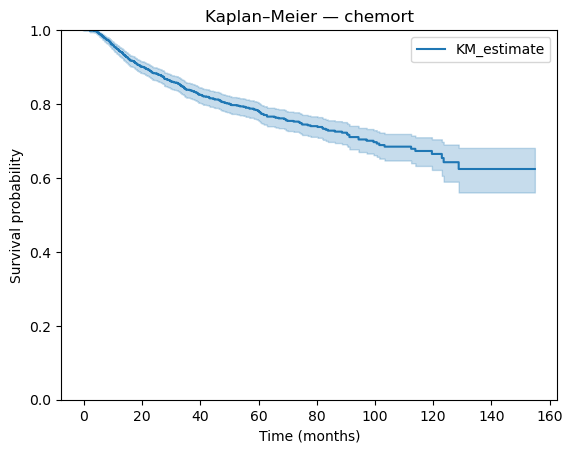

death_flag
0    1090
1     314
Name: count, dtype: int64


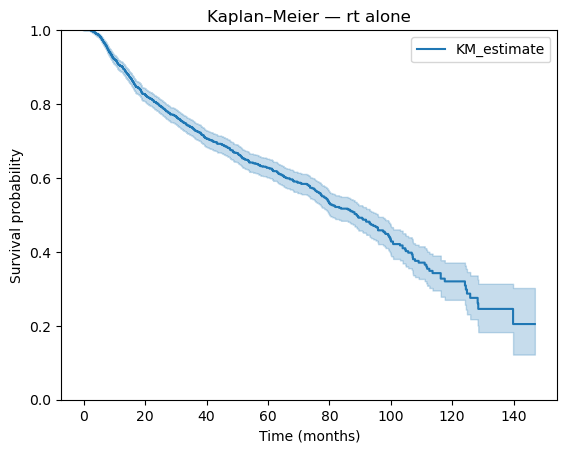

death_flag
0    1141
1     699
Name: count, dtype: int64


<bound method StatisticalResult.print_summary of <lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         119.10 <0.005     89.70>

In [35]:
#------- Kaplan-Meier Survival Curves for 2 groups (Treatment" ChemoRT and RT alone)

"""
def plot_kaplan_meier(data, colName):
    # Fit the Kaplan-Meier estimator
    kmf = KaplanMeierFitter()
    for col in data[colName].unique():
       subData = data.loc[data[colName] == col]
       print(subData['death_flag'].value_counts())
       kmf.fit(subData['time_months'], event_observed=subData['death_flag'], label = col)
    
    # Plot the Kaplan-Meier curve
    kmf.plot_survival_function()
    plt.title(f'Kaplan-Meier - {colName}')
    plt.xlabel('Time (Months)')
    plt.ylabel('Survival Probability')
    plt.tight_layout()
    plt.show()
"""

#plot for group  1: chemrt 
kmf = KaplanMeierFitter()
kmf.fit(chemort['time_months'], event_observed=chemort['death_flag'])
kmf.plot_survival_function()
plt.title('Kaplan–Meier — chemort')
plt.xlabel('Time (months)'); plt.ylabel('Survival probability'); plt.ylim(0,1)
plt.show()
print(chemort['death_flag'].value_counts())

#plot for group 2: rt alone 
kmf = KaplanMeierFitter()
kmf.fit(rt['time_months'], event_observed=rt['death_flag'])
kmf.plot_survival_function()
plt.title('Kaplan–Meier — rt alone')
plt.xlabel('Time (months)'); plt.ylabel('Survival probability'); plt.ylim(0,1)
plt.show()
print(rt['death_flag'].value_counts())

#Log rank test for group 1
results = logrank_test(
    chemort['time_months'], rt['time_months'],
    event_observed_A=chemort['death_flag'],
    event_observed_B=rt['death_flag']
)
results.print_summary
#log rank test for group 2

### Cox Propirtional Hazards Regression 

<lifelines.CoxPHFitter: fitted with 3244 total observations, 2222 right-censored observations>
             duration col = 'time_months'
                event col = 'death_flag'
      baseline estimation = breslow
   number of observations = 3244
number of events observed = 1022
   partial log-likelihood = -7430.50
         time fit was run = 2025-08-13 07:39:54 UTC

---
                           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                  
Age                        0.04      1.04      0.00            0.03            0.04                1.03                1.04
cancer_stage_II            0.28      1.33      0.15           -0.01            0.57                0.99                1.77
cancer_stage_III           0.67      1.95      0.14            0.40            0.93                1.49                2.54
cancer_stage_IVA           1.00      2.73      0.13            0.76            1.25                2.13                3.49
cancer_stage_IVB           1.80      6.07      0.14            1.52            2.09                4.58                8.05
treatment_type_rt + egfri  0.54      1.72      0.18            0.18            0.90                1.20                2.46
treatment_type_rt alone    0.79      2.21      0.08            0.63            0.95                1.88                2.59

                           cmp to     z      p  -log2(p)
covariate                                               
Age                          0.00 11.46 <0.005     98.52
cancer_stage_II              0.00  1.92   0.06      4.18
cancer_stage_III             0.00  4.88 <0.005     19.87
cancer_stage_IVA             0.00  7.96 <0.005     49.04
cancer_stage_IVB             0.00 12.54 <0.005    117.39
treatment_type_rt + egfri    0.00  2.95 <0.005      8.28
treatment_type_rt alone      0.00  9.77 <0.005     72.45
---
Concordance = 0.70
Partial AIC = 14875.00
log-likelihood ratio test = 474.81 on 7 df
-log2(p) of ll-ratio test = 324.49

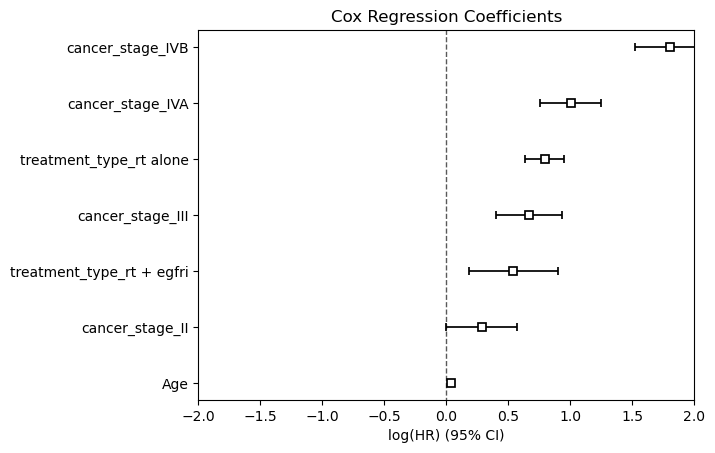


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3244 total observations, 2222 right-censored observations>
         test_name = proportional_hazard_test

---
                                test_statistic      p  -log2(p)
Age                       km             13.86 <0.005     12.31
                          rank           13.14 <0.005     11.75
cancer_stage_II           km              1.76   0.18      2.44
                          rank            0.97   0.32      1.62
cancer_stage_III          km             19.32 <0.005     16.46
                          rank           15.29 <0.005     13.41
cancer_stage_IVA          km             28.40 <0.005     23.28
                          rank           24.77 <0.005     20.56
cancer_stage_IVB          km             42.34 <0.005     33.61
                          rank           43.66 <0.005     34.58
treatment_type_rt + egfri km              0.57   0.45      1.15
                          rank            0.78   0.38      1.40
treatment_type_rt alone   km              0.08   0.77      0.37
                          rank            0.89   0.35      1.53



1. Variable 'Age' failed the non-proportional test: p-value is 0.0002.

   Advice 1: the functional form of the variable 'Age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Age' using pd.cut, and then specify it in `strata=['Age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


2. Variable 'cancer_stage_III' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['cancer_stage_III', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowes

[[<Axes: xlabel='rank-transformed time\n(p=0.0003)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0002)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3249)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1842)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0001)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3777)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4508)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3465)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7739)'>]]

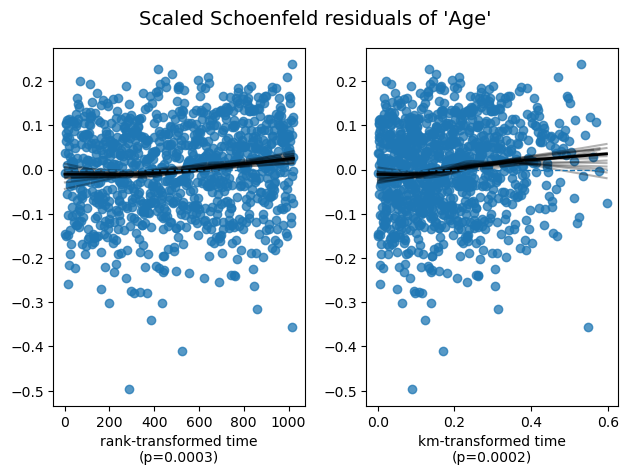

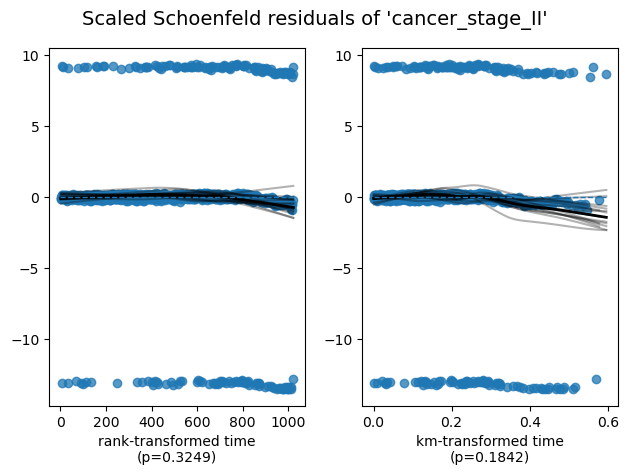

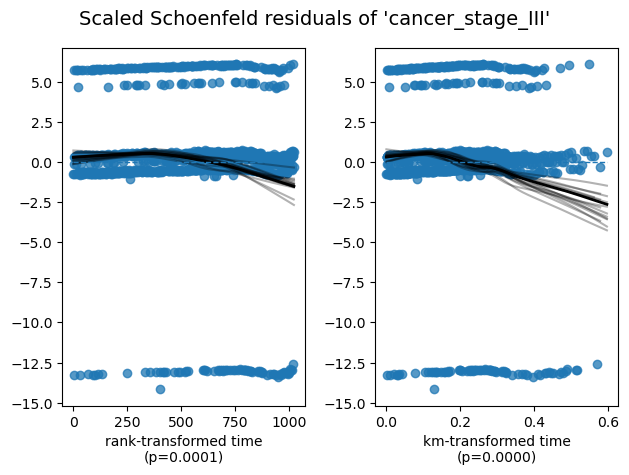

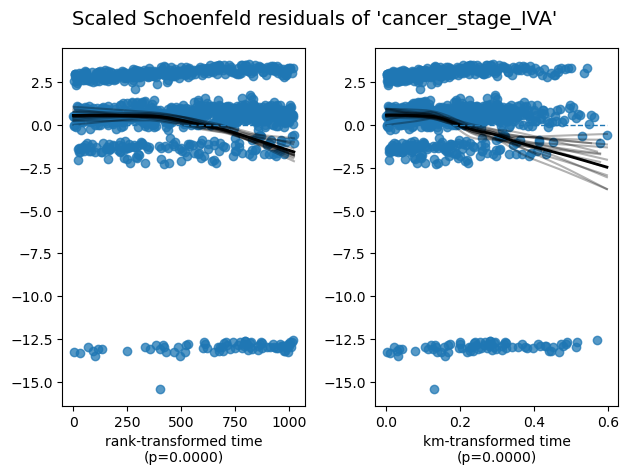

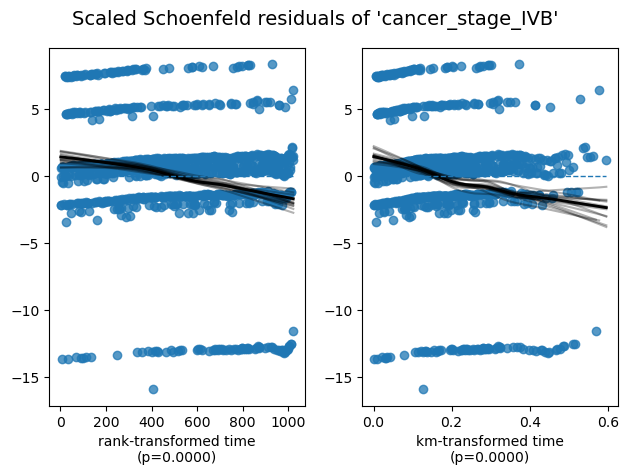

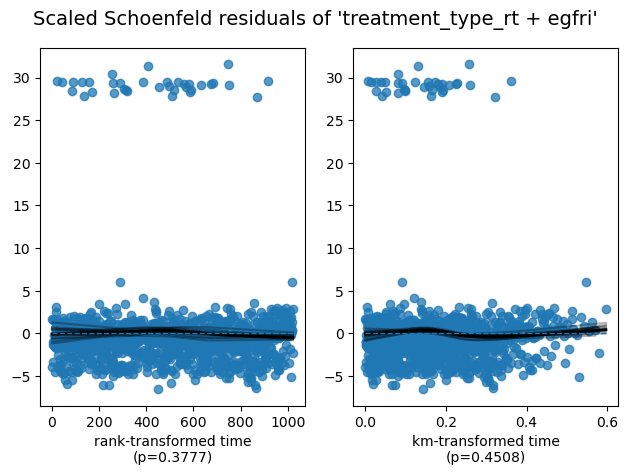

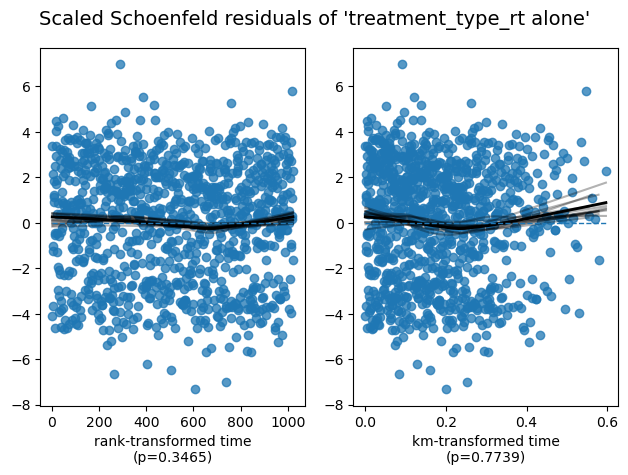

In [51]:
#----- Cox regression with at lead 3 covariates 
#covariates = ['Age', 'Sex', 'cancer_stage', 'treatment_type']
covariates = ['Age', 'cancer_stage', 'treatment_type']
df_cph = clean_data[['time_months', 'death_flag'] + covariates].copy()
df_cph = df_cph.dropna(subset=['time_months', 'death_flag']+ covariates)


# print(df_cph['Sex'].value_counts())
# print(df_cph['treatment_type'].value_counts())

min_count = 50 
for col in ['cancer_stage', 'treatment_type']:
    counts = df_cph[col].value_counts()
    low_patient = counts[counts < min_count].index
    df_cph = df_cph[~df_cph[col].isin(low_patient)]

#one hot encode categorical variables
cat_vars = ['cancer_stage', 'treatment_type']
#cat_vars = ['Sex', 'cancer_stage', 'treatment_type']
df_cph = pd.get_dummies(df_cph, columns=cat_vars, drop_first=True)

#print(df_cph.dtypes)

# Fit the Cox proportional hazards model
cph = CoxPHFitter()
cph.fit(df_cph, duration_col='time_months', event_col='death_flag')

# Print the summary of the model
cph.print_summary()

# Plot the coefficients
cph.plot()
plt.xlim(-2, 2)
plt.title('Cox Regression Coefficients')
plt.show()

#validate proptional hazard Assumptions
cph.check_assumptions(df_cph, p_value_threshold=0.05, show_plots=True)

### Random Survival Forests (RSF)

Age, 0.19537338579642313
treatment_type_rt alone, 0.09384107784483965
cancer_stage_IVA, 0.08802849239192415
cancer_stage_IVB, 0.07834711151083568
cancer_stage_III, 0.03664038492807163
cancer_stage_II, 0.015718940693376125
treatment_type_rt + egfri, 0.004825670348604542


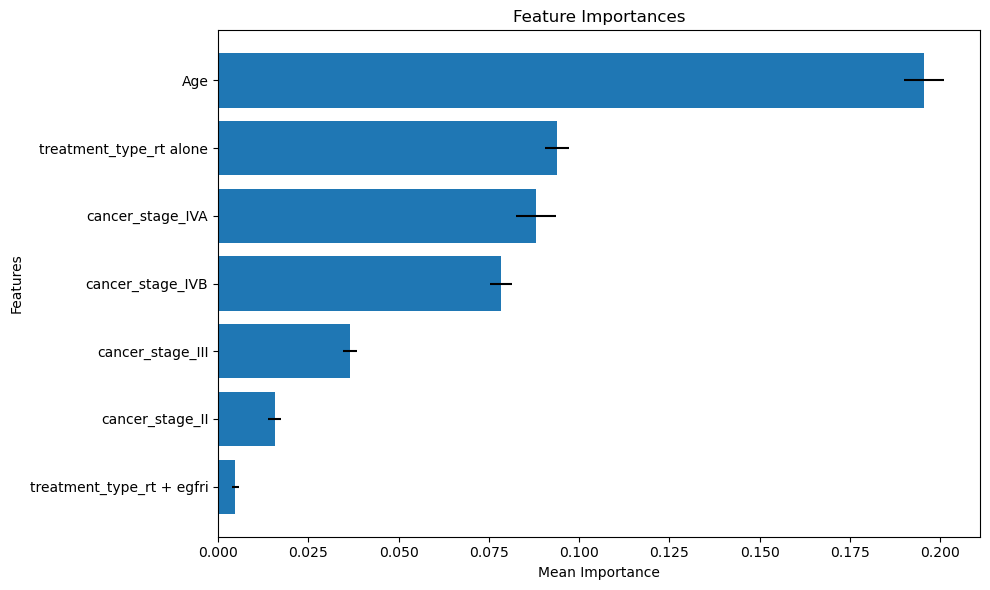

In [ ]:
#============BUILD RANDOM FOREST MODEL============#
rsf = RandomSurvivalForest(n_estimators=100, random_state=42)
df = df_cph.copy()

y = np.array(
    list(zip(df['death_flag'].astype(bool), df['time_months'].astype(float))),
    dtype =[('event','bool'), ('time','float64')]
)
df.drop(columns=['time_months','death_flag'], inplace = True)

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

rsf.fit(X_train, y_train)

#============VARIABLE IMPORTANCE ANALYSIS: finding predicitve factors============#
#referenced https://scikit-survival.readthedocs.io/en/stable/user_guide/random-survival-forest.html

result = permutation_importance(rsf, df, y, n_repeats=15, random_state=42)
feature_importance = pd.DataFrame(
    {
        k: result[k]
        for k in (
                "importances_mean",
                "importances_std"
        )
    },
    index=df.columns,
).sort_values(by = "importances_mean", ascending= False)

# Sort by importances_mean and plot
feature_importance = feature_importance.sort_values(by="importances_mean", ascending=False)

for fi in feature_importance.iterrows():
    print(f"{fi[0]}, {fi[1]["importances_mean"]}")

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(feature_importance.index, feature_importance['importances_mean'], xerr=feature_importance['importances_std'], align='center')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## RSF vs Cox Comparison

In [57]:
## compare RSF models concordance index (C-index) with Cox regression 
# Predict the risk scores on the test set
risk_scores = rsf.predict(X_test)

# Calculate the concordance index
c_index = concordance_index_censored(y_test['event'], y_test['time'], risk_scores)[0]
print(f'RSF Concordance Index: {c_index:.4f}')
print(f'CPH Concordance Index: {cph.concordance_index_:.4f}')

RSF Concordance Index: 0.6772
CPH Concordance Index: 0.6970
